# Assignment 1

1. Реализовать Блум фильтр с помощью битового массива.
Например, вы можете использовать [Битовые операции](https://wiki.python.org/moin/BitwiseOperators) или библиотеку bitarray.

2. Провести численный эксперимент при false postive rate = 0.05, и количестве объектов S = 1 000 000.
Убедится, полученные на семинаре оптимальные параметры фильтра позволяют достичь заявленного false positive rate.
Посчитать  $\frac {\epsilon - \hat \epsilon} \epsilon$, где $\hat \epsilon$ - ваша экспериментальная оценка false positive rate. В качестве объектов используйте строки.

In [1]:
from bitarray import bitarray
from math import log, ceil
from random import randint, choice

import matplotlib.pyplot as plt
%matplotlib inline

Тип, реализующий фильтр Блума с поддержкой автоматического вычисления оптимальных параметров и двойного хэширования и рассчитанный на работу со строками

In [35]:
class BloomFilter:
    
    def __init__(self, capacity=1000, fp_rate=0.05, n=None, k=None, dual_hashing=False):
        """
        capacity: num of items to be added
        fp_rate: FP rate
        n: num of bits (auto-computed if n=None)
        k: num of hash functions (auto-computed if k=None)
        dual_hashing: bool: dual hash items (slower)
        """
        
        self.capacity = capacity
        self.fp_rate = fp_rate 
        
        if n is None:
            self.n = self.__compute_n(self.capacity, self.fp_rate)
            
        else:
            self.n = n
            
        if k is None:
            self.k = self.__compute_k(self.capacity, self.n)
            
        else:
            self.k = k
        
        if dual_hashing:
            self.__hash_func = lambda _str, x, prime, i: (self.__hash_dual(_str, x, prime) + i) % self.n
            
        else:
            self.__hash_func = lambda _str, x, prime, i: (self.__hash_str(_str, x, prime) + i) % self.n
        
        self.__arr = bitarray(self.n)
        self.__arr.setall(False)
        
        self.PRIMES = [1291021, 1300711, 2014351, 2601773, 1158263,
                       2748973, 3315877, 4107991, 5603791, 8251349
                      ]
        
        self.k_primes = [choice(self.PRIMES) for _ in range(self.k)]
        self.k_xs = [randint(1, prime) for prime in self.k_primes]
    
    def __check_input(self, x):
        if not isinstance(x, str):
            
            try:
                x = str(x)
                return x
            
            except:
                raise Exception('expecting <str> or convertable to <str>')
        
        else:
            return x
    
    def __compute_n(self, capacity, fp_rate):
        return ceil((1 / log(2)**2) * capacity * log(1 / fp_rate))
    
    def __compute_k(self, capacity, n):
        return ceil((n / capacity) * log(2))
    
    def __hash_str(self, _str, x, prime):
        h = 0
        
        for i, s in enumerate(_str):
            h += ord(s) * x**i
        
        return h % prime
    
    def __hash_dual(self, _str, x, prime):
        h1 = 0
        h2 = ''
        
        for i, s in enumerate(_str):
            h1 += ord(s) * x**i
            h2 += str(ord(s))
            
        return h1 % prime + int(h2)
        
    
    def __hash(self, x):
        return [self.__hash_func(x, self.k_xs[i], self.k_primes[i], i) for i in range(self.k)] 
    
    def insert(self, x):
        x = self.__check_input(x)
        
        for bit in self.__hash(x):
            self.__arr[bit] = True
            
    def lookup(self, x):
        x = self.__check_input(x)
        
        for bit in self.__hash(x):
            
            if not self.__arr[bit]:
                return False
       
        return True

Ф-ия для проведения обозначенного эксперимента n-раз (вычисление эмпирического FP на основе вставки |S| элементов и look up проверки  других отличных |S| элементов)

In [43]:
def test_fp_rate(fp_rate, capacity, rounds=1, plot=True):
    """
    given estimated fr_rate as `fp_rate`
    compute observed fp_rate of `rounds` rounds of inserting `capacity` items
    then looking up for another `capacity` items
    """
    
    symbols = 'abcdefghijklmnopqrstuvwxyz'
    fp_rates = list()
    fp_diffs = list()
    
    
    for _round in range(rounds):
        bf = BloomFilter(capacity=capacity, fp_rate=fp_rate)
        n_errors = 0
        
        strs_to_insert= {''.join([choice(symbols) for _ in range(randint(1, 10))]): True for _ in range(capacity)}
        strs_to_lookup = [''.join([choice(symbols) for _ in range(randint(1, 10))]) for _ in range(capacity)]
        
        for _str_to_insert, _str_to_lookup in zip(strs_to_insert, strs_to_lookup):
            bf.insert(_str_to_insert)
            assert bf.lookup(_str_to_insert) is True
            
            if strs_to_insert.get(_str_to_lookup) is None and bf.lookup(_str_to_lookup):
                n_errors += 1
        
        fp_rates.append(n_errors / capacity)
        fp_diffs.append((fp_rate - (n_errors / capacity)) / fp_rate)
    
    if plot:
        plt.plot([1, rounds], [fp_rate] * 2, color='r', alpha=0.5, label='expected_fp_rate')
        plt.plot(range(1, rounds+1), fp_rates, color='b', alpha=0.5, label='observed_fp_rate')

        plt.title('%s rounds of inserting %s items' % (rounds, capacity))
        plt.xlabel('Rounds')
        plt.ylabel('FP rate')
        plt.legend(bbox_to_anchor=(1, 1))
    
    print('Mean FP rate: %s\nMean ((eps - eps_hat) / eps) score: %s'
          % (sum(fp_rates)/len(fp_rates), sum(fp_diffs)/len(fp_diffs)
            )
         )

Результаты 10-ти кратного повторения эксперимента

Mean FP rate: 0.015354800000000002
Mean ((eps - eps_hat) / eps) score: 0.6929040000000001
Wall time: 7min 33s


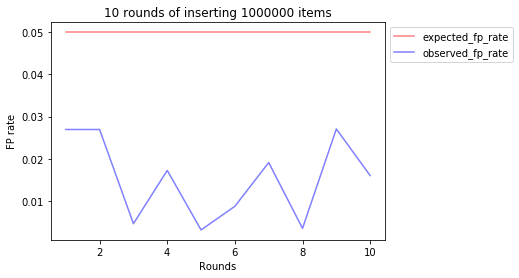

In [44]:
%%time
test_fp_rate(0.05, 10**6, 10)

Видно, что в каждом эксперименте полученное значение FP было ниже заявленного верхнего порога в 0.05, а его среднее составило 0.01<br>
Среднее же $\frac {\epsilon - \hat \epsilon} \epsilon$ оценки составило 0.69<br>
Итого, экспериментально мы убедились, что полученные на семинаре оптимальные параметры фильтра позволяют добиться заявленного FP и даже лучше